# 213 - Flea Circus

## Problem Statement

A $30 \times 30$ grid of squares contains $900$ fleas, initially one flea per square.<br>
When a bell is rung, each flea jumps to an adjacent square at random (usually $4$ possibilities, except for fleas on the edge of the grid or at the corners).

What is the expected number of unoccupied squares after $50$ rings of the bell? Give your answer rounded to six decimal places.

## Solution

For each flea, we compute the probability that it ends up in each of the cells after 50 rounds. The probability that the flea does not end up in the cell is the complement of this probability. For each cell, we multiply the probability that each flea does not end up in the cell. Finally, summing the probability of being empty for each cell gives the expected number of empty cells.

The code is relatively fast thanks to the numba speed-up (<1s) but can be quite slow without numba (still <1min). There are many possible optimisations for this problem. One is to leverage the symmetry of the problem. For example, $p(i, j) = p(j, i)$, the upper right 15x15 submatrix is equal to the top left 15x15 submatrix with flipped columns (similar argument can be made for the other 15x15 submatrices). Also, similar to a chess board, a flea can only move from a white square to a black square. Therefore, we can visit only half the squares in a given round. Finally it must be possible to avoid a lot of computation, particularly during the first rounds as we know the flea cannot get far from its starting position (see visualisation below). There are probably more optimisations.

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

@njit
def generate_probabilities(start_x, start_y, n_rounds):
    prev_grid = np.zeros((30, 30))
    prev_grid[start_x, start_y] = 1
    # Generate the probability the the flea ends up in each cell for 50 rounds
    for _ in range(n_rounds):
        grid = np.zeros((30, 30))
        # Compute probability that the flea ends up in each cell
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if 1 <= i < 29 and 1 <= j < 29:
                    grid[i, j + 1] += 1/4 * prev_grid[i][j]
                    grid[i, j - 1] += 1/4 * prev_grid[i][j]
                    grid[i + 1, j] += 1/4 * prev_grid[i][j]
                    grid[i - 1, j] += 1/4 * prev_grid[i][j]
                elif i == 0 and 1 <= j < 29:
                    grid[i, j + 1] += 1/3 * prev_grid[i][j]
                    grid[i, j - 1] += 1/3 * prev_grid[i][j]
                    grid[i + 1, j] += 1/3 * prev_grid[i][j]
                elif i == 29 and 1 <= j < 29:
                    grid[i, j + 1] += 1/3 * prev_grid[i][j]
                    grid[i, j - 1] += 1/3 * prev_grid[i][j]
                    grid[i - 1, j] += 1/3 * prev_grid[i][j]
                elif 1 <= i < 29 and j == 0:
                    grid[i, j + 1] += 1/3 * prev_grid[i][j]
                    grid[i + 1, j] += 1/3 * prev_grid[i][j]
                    grid[i - 1, j] += 1/3 * prev_grid[i][j]
                elif 1 <= i < 29 and j == 29:
                    grid[i, j - 1] += 1/3 * prev_grid[i][j]
                    grid[i + 1, j] += 1/3 * prev_grid[i][j]
                    grid[i - 1, j] += 1/3 * prev_grid[i][j]
                elif (i, j) == (0, 0):
                    grid[i + 1, j] += 1/2 * prev_grid[i][j]
                    grid[i, j + 1] += 1/2 * prev_grid[i][j]
                elif (i, j) == (0, 29):
                    grid[i + 1, j] += 1/2 * prev_grid[i][j]
                    grid[i, j - 1] += 1/2 * prev_grid[i][j]
                elif (i, j) == (29, 0):
                    grid[i - 1, j] += 1/2 * prev_grid[i][j]
                    grid[i, j + 1] += 1/2 * prev_grid[i][j]
                elif (i, j) == (29, 29):
                    grid[i - 1, j] += 1/2 * prev_grid[i][j]
                    grid[i, j - 1] += 1/2 * prev_grid[i][j]
        prev_grid = grid
    return grid

@njit
def get_expected_empty_cells():
    proba_empty = np.ones((30, 30))
    # first two loops determine the starting position of the flea
    for start_x in range(len(proba_empty)):
        for start_y in range(len(proba_empty[0])):
            grid = generate_probabilities(start_x, start_y, 50)
            # Get the probability that the flea is not in the cell for each cell
            for i in range(len(grid)):
                for j in range(len(grid[0])):
                    proba_empty[i, j] *= (1 - grid[i, j])

    # Sum the individual probabilities to get the expected number of empty cells
    res = np.sum(proba_empty)
    return round(res, 6)

get_expected_empty_cells()

330.721154

Below is a visualisation of the probability distribution of the ending flea position after some moves for a flea starting at $(7, 7)$.

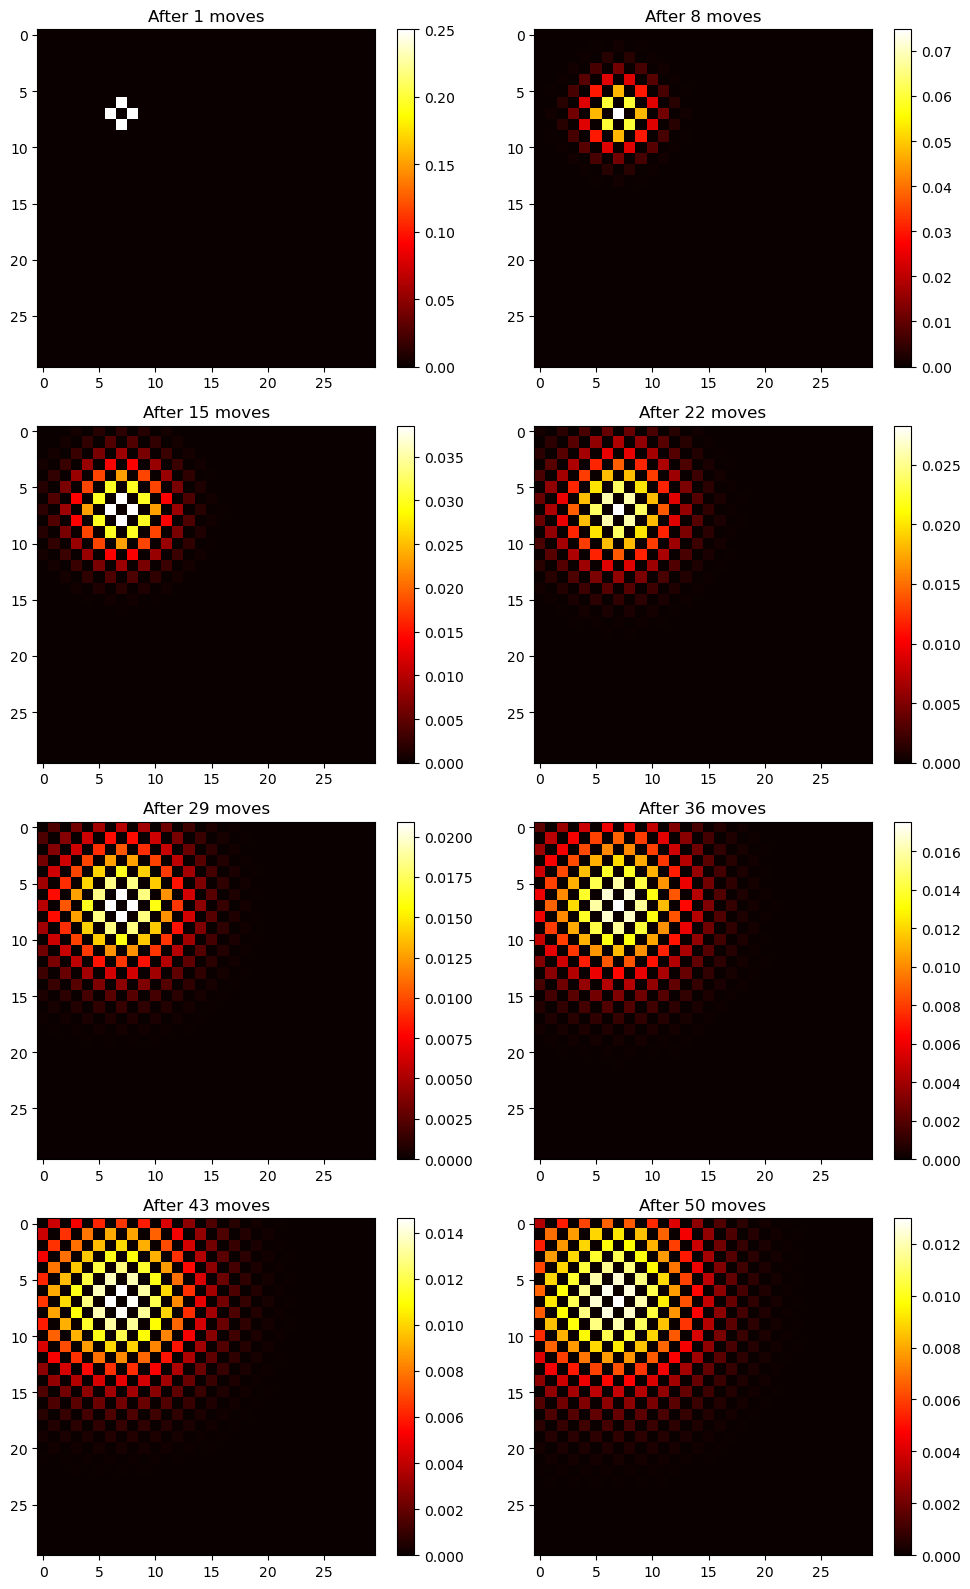

In [2]:
# Define number of plots per row
plots_per_row = 2
# Calculate total number of rows needed (7 plots, divided by 2 plots per row, rounded up)
total_rows = (50 // 7 + 1) // plots_per_row
# Create a figure and subplots
fig, axes = plt.subplots(total_rows, plots_per_row, figsize=(10, 4 * total_rows))
# Initialize plot count
plot_count = 0

# Starting position of the flea
start_x, start_y = 7, 7

# Generate flea end position probability distribution
prev_grid = np.zeros((30, 30))
prev_grid[start_x, start_y] = 1
for k in range(50):
    grid = np.zeros((30, 30))
    # Compute probability that the flea ends up in each cell
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if 1 <= i < 29 and 1 <= j < 29:
                grid[i, j + 1] += 1/4 * prev_grid[i][j]
                grid[i, j - 1] += 1/4 * prev_grid[i][j]
                grid[i + 1, j] += 1/4 * prev_grid[i][j]
                grid[i - 1, j] += 1/4 * prev_grid[i][j]
            elif i == 0 and 1 <= j < 29:
                grid[i, j + 1] += 1/3 * prev_grid[i][j]
                grid[i, j - 1] += 1/3 * prev_grid[i][j]
                grid[i + 1, j] += 1/3 * prev_grid[i][j]
            elif i == 29 and 1 <= j < 29:
                grid[i, j + 1] += 1/3 * prev_grid[i][j]
                grid[i, j - 1] += 1/3 * prev_grid[i][j]
                grid[i - 1, j] += 1/3 * prev_grid[i][j]
            elif 1 <= i < 29 and j == 0:
                grid[i, j + 1] += 1/3 * prev_grid[i][j]
                grid[i + 1, j] += 1/3 * prev_grid[i][j]
                grid[i - 1, j] += 1/3 * prev_grid[i][j]
            elif 1 <= i < 29 and j == 29:
                grid[i, j - 1] += 1/3 * prev_grid[i][j]
                grid[i + 1, j] += 1/3 * prev_grid[i][j]
                grid[i - 1, j] += 1/3 * prev_grid[i][j]
            elif (i, j) == (0, 0):
                grid[i + 1, j] += 1/2 * prev_grid[i][j]
                grid[i, j + 1] += 1/2 * prev_grid[i][j]
            elif (i, j) == (0, 29):
                grid[i + 1, j] += 1/2 * prev_grid[i][j]
                grid[i, j - 1] += 1/2 * prev_grid[i][j]
            elif (i, j) == (29, 0):
                grid[i - 1, j] += 1/2 * prev_grid[i][j]
                grid[i, j + 1] += 1/2 * prev_grid[i][j]
            elif (i, j) == (29, 29):
                grid[i - 1, j] += 1/2 * prev_grid[i][j]
                grid[i, j - 1] += 1/2 * prev_grid[i][j]
    prev_grid = grid

    if k % 7 == 0:
        # Determine which subplot to use
        row = plot_count // plots_per_row
        col = plot_count % plots_per_row
        ax = axes[row, col]
        # Plot on the determined subplot
        cax = ax.imshow(grid, cmap='hot', interpolation='nearest')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'After {k+1} moves')
        # Increment plot count
        plot_count += 1

plt.tight_layout()
plt.show()